In [93]:
import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd
plt.style.use('../../../nico_general.mplstyle')

In [7]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [8]:
from numba import njit

@njit
def euler_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = x[i-1] + (y[i-1] - x[i-1]) * c

        
@njit
def rush_larsen_easy_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c)
        
@njit
def rush_larsen_numba_helper(x, y, c):
    for i in range(1, len(x)):
        x[i] = y[i-1] + (x[i-1] - y[i-1]) * np.exp(c[i-1])
 

In [68]:

        
@njit
def calculate_step(s, a, i_out, c):
    
    s_new = np.zeros(len(s))
    
    v_cp, v_p, v_m , m, h = s
    m_inf, h_inf, tau_m, tau_h = a
    c_p, c_m , r_p, r_m , v_c,  dt = c
    
    
    s_new[0] = v_c
    s_new[1] = v_c + (v_p - v_c)*np.exp(-dt / (r_p * c_p))
    s_new[2] = v_m + (v_p - v_m)*dt / (r_m * c_m) - 1e-9*i_out*dt/c_m 
    s_new[3] = m_inf + (m - m_inf)*np.exp(-dt/tau_m)
    s_new[4] = h_inf + (h - h_inf)*np.exp(-dt/tau_h)
    
    
    return s_new



@njit
def calculate_algebraic(v, a):
    a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, v_half_m, v_half_h, k_m, k_h = a
    
    alpha_m  = a0_m * np.exp(-delta_m * v / (-s_m)) 
    beta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
    #print(v)

    alpha_h  = a0_h * np.exp(-delta_h * v / s_h) 
    beta_h = b0_h * np.exp((1-delta_h) * v / s_h)

    
    tau_m = 1/(beta_m + alpha_m)
    tau_h = 1/(beta_h + alpha_h)

    m_inf = 1/(1+np.exp((-v_half_m-v)/k_m))
    h_inf = 1/(1+np.exp((v_half_h+v)/k_h))
    #m_inf = 1/(1+beta_m/alpha_m)
    #h_inf = 1/(1+beta_h/alpha_h)

    return m_inf, h_inf, tau_m, tau_h

def calculate_I_out(x, *args):#, s0, c, protocol, ...):

    kwargs = args[-1]
    
    t = kwargs['t']
    v_list = kwargs['v_list']
    k_list = kwargs['k_list']
    
    if kwargs.get('log_scale', False):
        x = np.exp(x)
        assert np.all(x > 0) 
    
    
    c_p, c_m, a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, r_m, r_p, g_max, g_leak, v_half_m, v_half_h, k_m, k_h = x

    v_c = np.zeros_like(t)

    count = np.zeros_like(t)
    count[k_list] = 1
    count = np.cumsum(count)    
    
    v_c = v_list[count.astype(int)]


    dt = t[1] - t[0]
    n_step = len(t)
               
    algebraic = np.zeros((n_step, 4))
    I = np.zeros((len(t), 5))
    
    #             v_cp  v_p  v_m  m  h  
    s0 = np.array([-80, -80, -80, 0, 1]) #, 0, 0, 0]           
    
    s_array = np.zeros((n_step, len(s0)))
    s_array[0] = s0
    #s_array[:, 0] = v_c
    #print(s_array)
    
    v_rev =18
    tau_z = 5e-4 # 1e-12 * 5e8
    I_out = np.zeros_like(t)
    
    #print(s_array[0])     
    #v_cp = V_m_list + np.concatenate([[0],np.diff(V_m_list)])*(prediction/(1-prediction))*np.exp(-t/(C_m_prediction*R_srp))                          
    for i in range(1, n_step):
        s = s_array[i-1]
        a = calculate_algebraic(s[2],
                                (a0_m, b0_m, delta_m, s_m, a0_h, b0_h, delta_h, s_h, v_half_m, v_half_h, k_m, k_h),
                                )
        #print(s[2])
        algebraic[i-1] = a
        try:
            s_new = calculate_step(s, a, I_out[i-1],
                               (c_p, c_m, r_p, r_m, v_c[i-1], dt),
                               )
        except ZeroDivisionError:
            s_new = np.zeros(5)
    
        
        s_array[i] = s_new
        
        i_c = 1e9 * c_m * (s_new - s)[2] / dt
        i_p = 1e9 * c_p * (s_new - s)[1] / dt
        i_leak = g_leak * s_new[2]
        i_na = g_max * s_new[4] * (s_new[3]**3) * (s_new[2] - v_rev)
        i_in = i_c + i_p + i_leak + i_na

        I_in = i_c, i_p, i_leak, i_na , i_in
        I[i-1] = I_in
        I_out[i] = I_out[i-1] + (sum(I_in) - I_out[i-1]) * (dt / tau_z)
   # print(I_out)
        
    algebraic[-1] = algebraic[-2]
        
    if kwargs.get('graph', True):
        #plt.plot(V_m_list, label = 'command')
        
        plt.plot(s_array[:, 0], label = 'command_prediction')
        plt.plot(s_array[:, 1], label = 'pipette', ls = '--')
        plt.plot(s_array[:, 2], label = 'membrane')
        plt.legend()
        

        
        plt.figure() 
        plt.plot(s_array[:, 2], algebraic [:,0], label = 'm_inf')
        plt.plot(s_array[:, 2], algebraic [:,1], label = 'h_inf')
        plt.legend()
        
        plt.figure() 
        plt.plot(s_array[:, 2], algebraic [:,2], label = 'tau_m')
        plt.plot(s_array[:, 2], algebraic [:,3], label = 'tau_h')
        plt.legend()

        plt.figure()
        plt.plot(I[:,0], label = 'Ic')
        plt.plot(I[:,1], label = 'Ip')
        plt.plot(I[:,2], label = 'Ileak')
        plt.plot(I[:,3], label = 'Ina')
        plt.legend()
        
        plt.figure()
        plt.plot(I_out, label = 'I_out')
        plt.legend()
        
    return I_out

In [69]:
k_list = np.array([77, 1077, 2077, 4077])
v_list = np.array([-80, -70, -80, -80])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])


In [70]:
k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80,-70,-80, -10, -80])

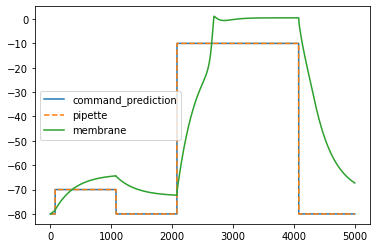

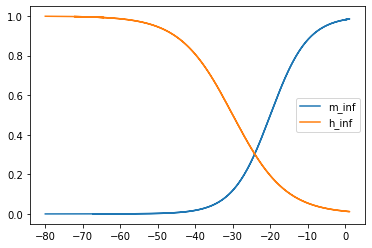

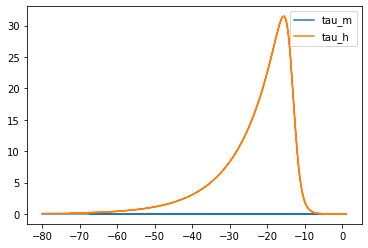

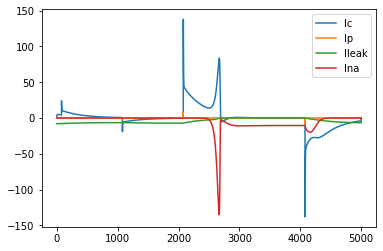

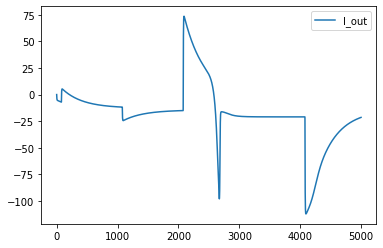

In [71]:

x_true = [6e-15, 12e-12, 5e4,  8e-2,   0.3,   60,  1e-3,   4e2,    0.08,     22,    5e8,   1e6,   5e1,   1e-1]
p0 = np.array([6e-15, 12e-12, 90,  8e1,0.2,   100,    6e-3,   4e3,    0.1,  1,    5e8,   5e3,   5e1,   1e-1,20,30,5,7])
#             C_p     C     a0_m  b0_m  delta_m  s_m   a0_h  b0_h    delta_h      s_h      R    R_p   g_max  g_leak


x_true_log = np.log(p0)

t = np.load('../data/time.npy')

v_list = v_all#np.array([-80, -80, -70, -80, -10, -80])
k_list = k_all#np.array([77, 1077, 2077, 4077]) 
dt = t[1] - t[0]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = True)#,
              #sample_weights = sample_weight)

data = calculate_I_out(x_true_log, kwargs) 
#data_1 = calculate_I_out(x_true_log, kwargs) 



In [44]:
sample_weight = np.zeros(5000)
sample_weight[:]+= 1
#sample_weight[k_list_1[2]+40:k_list_1[2]+900] += 1
#sample

In [73]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    sample_weight = kwargs.get('sample_weight', None)
    I_out = calculate_I_out(x, *args)
    
    if np.any(np.isnan(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

In [75]:
%%timeit

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
loss(x_true_log, data, kwargs)

80.1 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [100]:
names =  ["C_f","C","a0_m","b0_m","delta_m","s_m","a0_h","b0_h" ,"delta_h","s_h","R"   , "R_f"  , "g_max"  ,"g_leak", "v_half_m", "v_half_h", "k_m", "k_h" ]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)
x0 = x_true_log - 0.5
bounds = np.vstack([x_true_log  - 3, x_true_log + 3]).T
loss(x_true_log, data, kwargs)

0.0

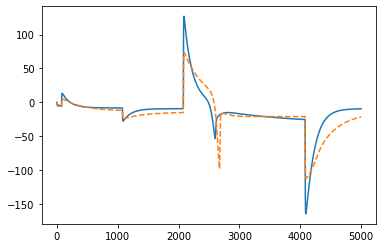

In [77]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [78]:
%%time
res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs))

CPU times: user 20min 20s, sys: 5.64 s, total: 20min 25s
Wall time: 20min 24s


In [79]:
loss(res.x, data, kwargs)

0.000361743591904177

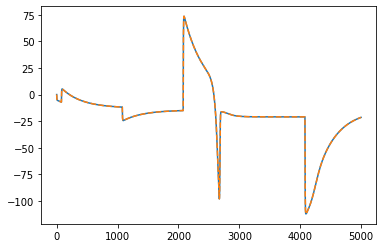

In [83]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '--')

 ### real_data_minimize


In [87]:
real_data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
real_data_small = real_data[14]
#real_data = np.concatenate([real_data[k] for k in range(1,21)])

#sample_weights = np.zeros(5000)
#sample_weights[2210:4000] += 1


#           C_f     C    a0_m   b0_m    delta_m   s_m    a0_h   b0_h   delta_h  s_h      R    R_f   g_max g_leak
#bounds = ([1e-20, 1e-13, 1e-10, 1e-10,  1e-10,   1e-10,  1e-10, 1e-10, 1e-10,   1e-10,  1e5,  1e3,  1e-5, 1e-5],
#          [1e-9,  1e-10, 1e8,   1e6,    1,       1e4,    1e8,   1e8,   1,       1e8,    1e15, 1e15, 1e5,  1e5])
#log_bounds = np.vstack([np.log(bounds[0]),np.log(bounds[1])]).T
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = False)#,
              #sample_weight = sample_weights)


In [89]:
%%time
res = scop.minimize(loss, x_true_log, bounds=bounds, args=(real_data_small, kwargs))#, tol = 1e-6)#,method = 'Nelder-Mead',
               #options={'maxfev':5e10, 'adaptive':True})

CPU times: user 12min 31s, sys: 3.94 s, total: 12min 35s
Wall time: 12min 36s


In [90]:
loss(res.x, real_data_small, kwargs)

228.44732443710248

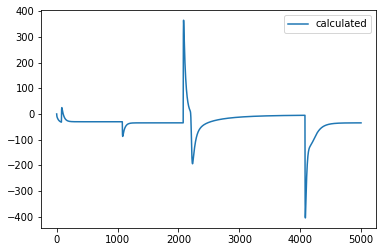

In [91]:
plt.plot(calculate_I_out(res.x, kwargs), label = 'calculated')

plt.legend()
#plt.axvline(2210)
#plt.plot(real_data_small, '--', label = 'real data')

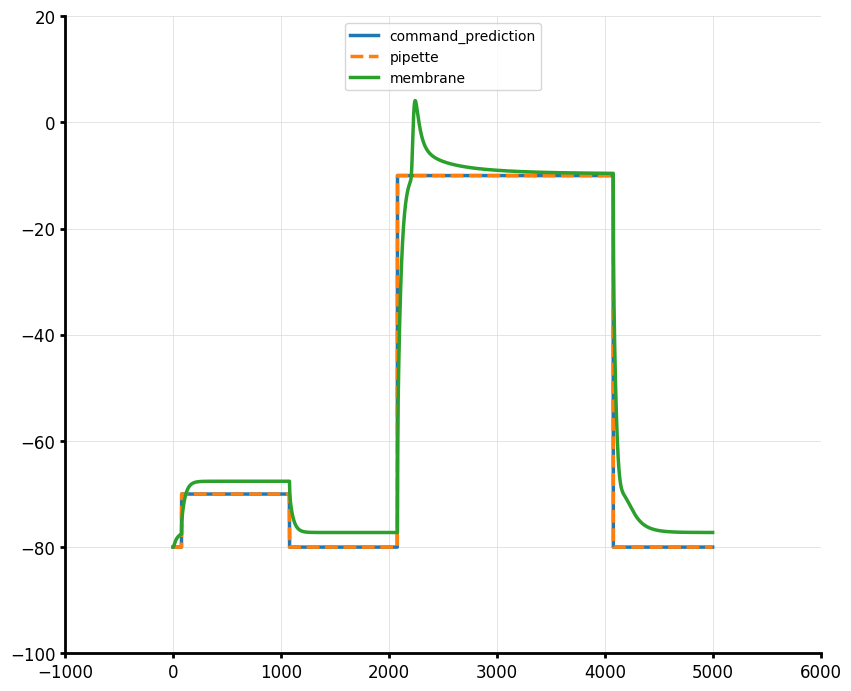

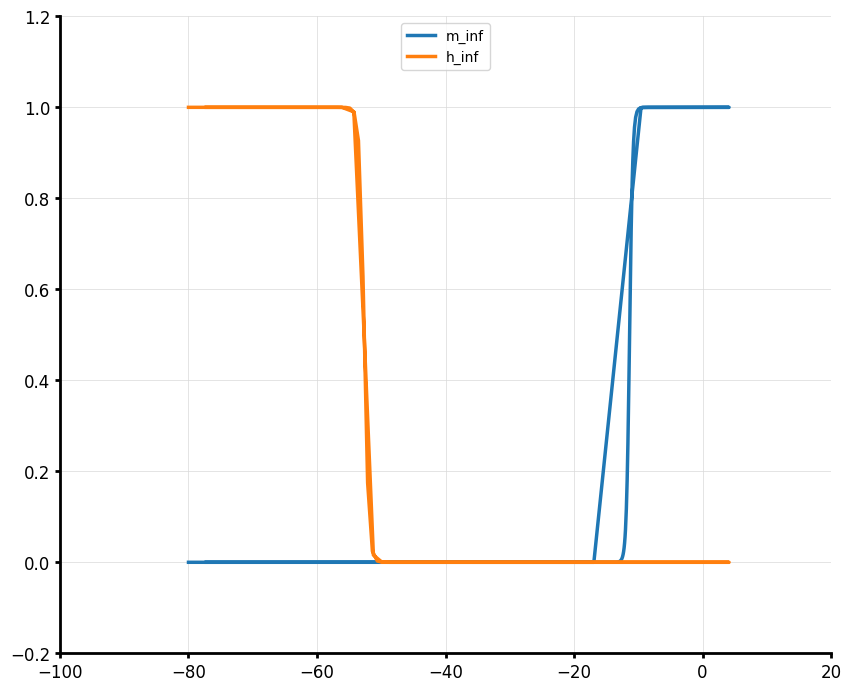

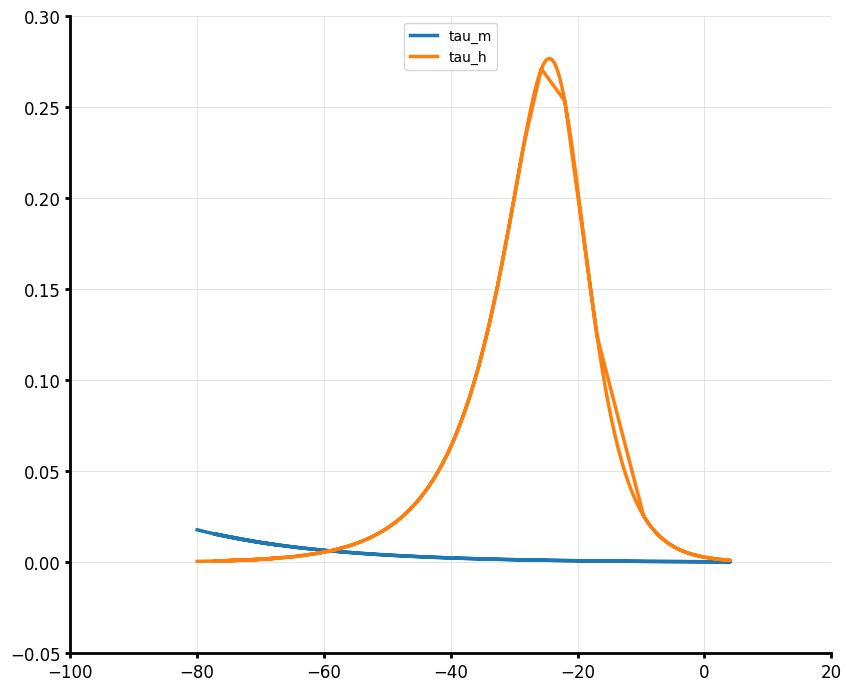

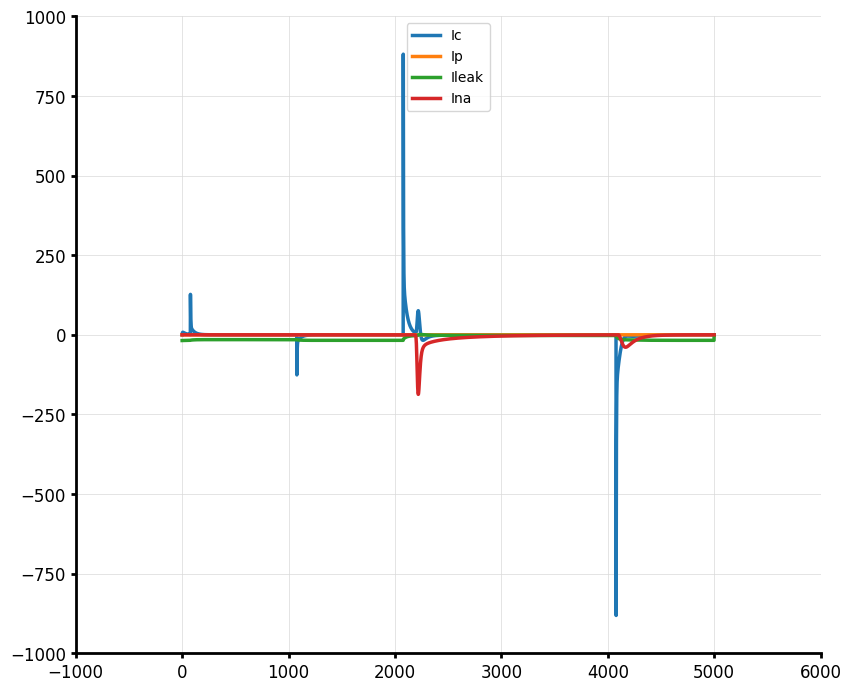

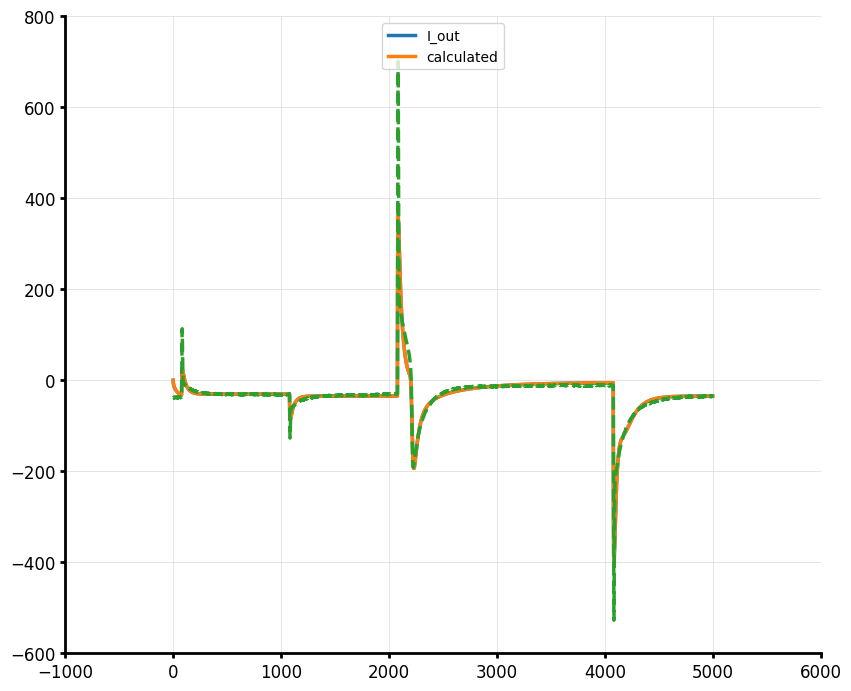

In [94]:
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t,
              log_scale = True,
              graph = True)#,
              #sample_weight = sample_weights)
plt.plot(calculate_I_out(res.x, kwargs), label = 'calculated')

plt.legend()
#plt.axvline(2210)
plt.plot(real_data_small, '--', label = 'real data')

In [98]:
#plt.scatter(names,log_bounds.T[0], marker = '_', s = 500, c = 'k')
#plt.scatter(names,log_bounds.T[1], marker = '_', s = 500, c = 'k')
#plt.scatter(names, res.x)

In [101]:
for k in range(len(res.x)):
    print(names[k], ' = ',np.exp(res.x)[k])

C_f  =  2.9872241020718387e-16
C  =  6.0058543498825735e-12
a0_m  =  1807.69832308689
b0_m  =  1606.8429538550129
delta_m  =  4.017107384637534
s_m  =  66.19640134589488
a0_h  =  0.12051322153912597
b0_h  =  355.08323147338797
delta_h  =  0.3449697649543877
s_h  =  2.832345210074643
R  =  79434372.37204513
R_f  =  5000.000000000004
g_max  =  13.05507350893644
g_leak  =  0.22440106957648723
v_half_m  =  11.360889034332539
v_half_h  =  52.66597542400465
k_m  =  0.2489353418393197
k_h  =  0.34850947857504755


### differential_evolution

In [ ]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=log_bounds,
                                  args=(real_data_small, kwargs),
                                  maxiter=10, # I don't want to wait too long
                                  #disp=True,
                                  workers=-1,
                                  seed=42,
                                  )

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:495: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning:

<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figu

<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: Runtim

<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarni

<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: Runtim

<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: di

<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: Runtim

<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: Runtim

<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: Runtim

<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide b

<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in multiply
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: div

<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:71: RuntimeWarning: overflow encountered in exp
  alfa_m  = a0_m * np.exp(-delta_m * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:81: RuntimeWarning: divid

<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: di

<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero

<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarni

<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: RuntimeWarni

<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: 

<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:74: 

<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarni

<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: Runtim

<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:88: 

<ipython-input-3-14d5f6d84868>:74: RuntimeWarning: overflow encountered in exp
  alfa_h  = a0_h * np.exp(-delta_h * v / s_h)
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:89: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(h, h_inf, -dt / tau_h)
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:88: RuntimeWarning: divide by zero encountered in true_divide
  rush_larsen_numba_helper(m, m_inf, -dt / tau_m)
<ipython-input-3-14d5f6d84868>:71: RuntimeWarning: overflow encountered in exp
  alfa_m  = a0_m * np.exp(-delta_m * v / (-s_m))
<ipython-input-3-14d5f6d84868>:72: RuntimeWarning: overflow encountered in exp
  betta_m = b0_m * np.exp((1-delta_m) * v / (-s_m))
<ipython-input-3-14d5f6d84868>:75: RuntimeWarning: overf

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')

### dual_annealing

In [ ]:
%%time
res = scop.dual_annealing(loss, bounds=log_bounds, x0 = x_true_log, args=(real_data_small, kwargs), seed=42)

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')